## Machine Learning and Artificial Intelligence, MSc Business Mathematics
## Online Retail Analysis Project
### Angelos Semoglou, s3332318
#### **`Part 1: Data Preparation, Exploratory Analysis, NLP-Driven Product Categorization`**

***

In [1]:
import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from wordcloud import WordCloud
import squarify
import plotly.graph_objs as go
from plotly.offline import iplot

"""
If needed
# Initialize nltk components
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

# install wordcloud 
!pip install wordcloud
"""

"\nIf needed\n# Initialize nltk components\nnltk.download('punkt')\nnltk.download('averaged_perceptron_tagger')\nnltk.download('stopwords')\nnltk.download('wordnet')\n\n# install wordcloud \n!pip install wordcloud\n"

***

### Load Data (Invoices) 

#### Information: [Online Retail, UCI ML Repository](https://archive.ics.uci.edu/dataset/352/online+retail)

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

In [2]:
data = pd.read_excel('online_retail.xlsx')
print(f'\nNumber of Data (Invoices): {data.shape[0]}')
print(f'Number of Data Columns: {data.shape[1]}\n')
display(data.head(3))


Number of Data (Invoices): 541909
Number of Data Columns: 8



InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                 WHITE METAL LANTERN         6   
2    536365    84406B      CREAM CUPID HEARTS COAT HANGER         8   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom

**Variables**:
- `InvoiceNo`: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
- `StockCode`: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- `Description`: Product (item) name. Nominal.
- `Quantity`: The quantities of each product (item) per transaction. Numeric.	
- `InvoiceDate`: Invoice Date and time. Numeric, the day and time when each transaction was generated.
- `UnitPrice`: Unit price. Numeric, Product price per unit in sterling.
- `CustomerID`: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- `Country`: Country name. Nominal, the name of the country where each customer resides. 

### Initial Data Setup: Preparation and Feature Engineering

In [3]:
all_data = data.copy() # To preserve the integrity of the original data

- ### Data Renaming

In [4]:
# Create a mapping dictionary to rename the columns for better readability
mapping = {
    'InvoiceNo': 'invoice_id',      
    'StockCode': 'product_id',
    'Description': 'description',
    'Quantity': 'quantity',
    'InvoiceDate': 'invoice_date',
    'UnitPrice': 'price_per_unit',
    'CustomerID': 'customer_id',
    'Country': 'country'
}
# Rename the columns in the copied dataset using the mapping dictionary
all_data.rename(columns = mapping, inplace = True)

- ### Data Cleaning: Deduplication and Removing Missing `'customer_id'` Rows

In [5]:
# Check for and print the number of duplicate entries in the dataset
print('- Duplicates: {}'.format(all_data.duplicated().sum()))

# Remove duplicates
all_data.drop_duplicates(inplace = True)

# Check for and print the number of missing values in 'customer_id'
missing_id = all_data['customer_id'].isnull().sum()
print(f"- Missing 'customer_id' values: {missing_id}\n")

# Drop rows where 'customer_id' is missing
all_data.dropna(subset = ['customer_id'], inplace = True)

# Data remains after removal
print(f"Data (Rows) after dropping duplicates and missing 'customer_id': {all_data.shape[0]}")

- Duplicates: 5268
- Missing 'customer_id' values: 135037

Data (Rows) after dropping duplicates and missing 'customer_id': 401604


- ### Data Type Conversion

In [6]:
# Convert the 'customer_id' column to string type 
all_data['customer_id'] = all_data['customer_id'].astype(str)   

# Convert the 'invoice_date' column to datetime type
all_data['invoice_date'] = pd.to_datetime(all_data['invoice_date'])

# Create a DataFrame to hold column type information
col_type = pd.DataFrame(all_data.dtypes).T.rename(index={0: 'type'})

# Create DataFrame for number of null values
nv = pd.DataFrame(all_data.isnull().sum()).T.rename(index={0: 'null values'})

# Concatenate all the DataFrames
col_type = pd.concat([col_type, nv])

display(col_type)

invoice_id product_id description quantity    invoice_date  \
type            object     object      object    int64  datetime64[ns]   
null values          0          0           0        0               0   

            price_per_unit customer_id country  
type               float64      object  object  
null values              0           0       0

- ### Handling Cancellations/Returns
  **Cancellations**: Transactions/Rows that are not Discounts (`'description'` $\neq$ `'Discount'`)  with negative `'quantity'` where the `'invoice_id'` starts with 'C'.

     1. Negative `'quantity'` transactions are considered potential returns if there exists a corresponding prior positive transaction with the same `product_id` from the same `'customer_id'`. This ensures that the negative transaction is a genuine return and not an error or irregularity.
     2. If no corresponding positive transaction exists before the negative one, it is treated as a cancellation. It is important to note that some cancellations might be genuine returns without a recorded prior purchase. For such cancellations, we remove these entries from the dataset to correct the data and avoid skewing our analysis.

In [7]:
# Potential Cancellations
potential_c = all_data[(all_data['quantity'] < 0) & (all_data['description'] != 'Discount')]
display(potential_c.head(3))

invoice_id product_id                       description  quantity  \
154    C536383     35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235    C536391      22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236    C536391      21984  PACK OF 12 PINK PAISLEY TISSUES        -24   

           invoice_date  price_per_unit customer_id         country  
154 2010-12-01 09:49:00            4.65     15311.0  United Kingdom  
235 2010-12-01 10:24:00            1.65     17548.0  United Kingdom  
236 2010-12-01 10:24:00            0.29     17548.0  United Kingdom

In [8]:
# Cancellations / Returns
cancellations = all_data[(all_data['quantity'] < 0) & (all_data['description'] != 'Discount')].copy()
cancellations['index_cancel'] = cancellations.index  # Add an index column for reference

# Original Purchases
purchases = all_data[all_data['quantity'] > 0].copy()
purchases['index_purchase'] = purchases.index  # Add an index column for reference

potential_returns = pd.merge(
    cancellations,
    purchases,
    on=['customer_id', 'product_id'],
    suffixes=('_cancel', '_purchase'),
    how='left'
)

# Filter to ensure the purchase happened before the cancellation
potential_returns = potential_returns[
    (potential_returns['invoice_date_purchase'] < potential_returns['invoice_date_cancel']) &
    (potential_returns['invoice_date_purchase'].notna())
]

potential_return_indices = set(potential_returns['index_cancel'])

# Negative Transactions without a Counterpart
potential_cancellations_indices = set(cancellations.index) - potential_return_indices

potential_cancellations_indices_list = list(potential_cancellations_indices)

# Drop the identified potential cancellations
all_data.drop(potential_cancellations_indices_list, axis=0, inplace=True)

# Count the number of adjustments made
n = len(potential_cancellations_indices_list)
m = len(potential_return_indices)

# Print the number of identified potential returns and cancellations
print(f"Number of Identified Potential Returns: {m}")
print(f"Number of Identified Potential 'Cancellations' (Number of adjustments): {n}")

Number of Identified Potential Returns: 7569
Number of Identified Potential 'Cancellations' (Number of adjustments): 1226


- ### Data Transformation: Compute Adjusted Prices & Convert and Extract Dates

In [9]:
# Add new column: 'invoice_amount' 
all_data['invoice_amount'] = all_data['price_per_unit']*all_data['quantity']

# Extracting year, month, day from 'invoice_date'
all_data['year'] = all_data['invoice_date'].dt.year
all_data['month'] = all_data['invoice_date'].dt.month
all_data['day'] = all_data['invoice_date'].dt.day
all_data['hour'] = all_data['invoice_date'].dt.hour 

# Add Season Column using 'month' values
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
        
all_data['season'] = all_data['month'].apply(get_season)

In [10]:
display(all_data.head(3))

invoice_id product_id                         description  quantity  \
0     536365     85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365      71053                 WHITE METAL LANTERN         6   
2     536365     84406B      CREAM CUPID HEARTS COAT HANGER         8   

         invoice_date  price_per_unit customer_id         country  \
0 2010-12-01 08:26:00            2.55     17850.0  United Kingdom   
1 2010-12-01 08:26:00            3.39     17850.0  United Kingdom   
2 2010-12-01 08:26:00            2.75     17850.0  United Kingdom   

   invoice_amount  year  month  day  hour  season  
0           15.30  2010     12    1     8  Winter  
1           20.34  2010     12    1     8  Winter  
2           22.00  2010     12    1     8  Winter

***

### Exploratory Data Analysis

In [11]:
display(all_data.describe())

quantity                   invoice_date  price_per_unit  \
count  400378.000000                         400378   400378.000000   
mean       12.275485  2011-07-10 19:23:54.097977600        3.237926   
min    -80995.000000            2010-12-01 08:26:00        0.000000   
25%         2.000000            2011-04-07 11:37:00        1.250000   
50%         5.000000            2011-07-31 11:45:00        1.950000   
75%        12.000000            2011-10-20 12:11:00        3.750000   
max     80995.000000            2011-12-09 12:50:00     8142.750000   
std       250.199950                            NaN       25.428670   

       invoice_amount           year          month            day  \
count   400378.000000  400378.000000  400378.000000  400378.000000   
mean        20.972739    2010.935119       7.596274      15.044795   
min    -168469.600000    2010.000000       1.000000       1.000000   
25%          4.250000    2011.000000       5.000000       7.000000   
50%         11.700000    2011.000000       8.000000      15.000000   
75%         19.800000    2011.000000      11.000000      22.000000   
max     168469.600000    2011.000000      12.000000      31.000000   
std        426.005066       0.246316       3.414232       8.653101   

               hour  
count  400378.00000  
mean       12.72999  
min         6.00000  
25%        11.00000  
50%        13.00000  
75%        14.00000  
max        20.00000  
std         2.28774

- ### Sales Analysis

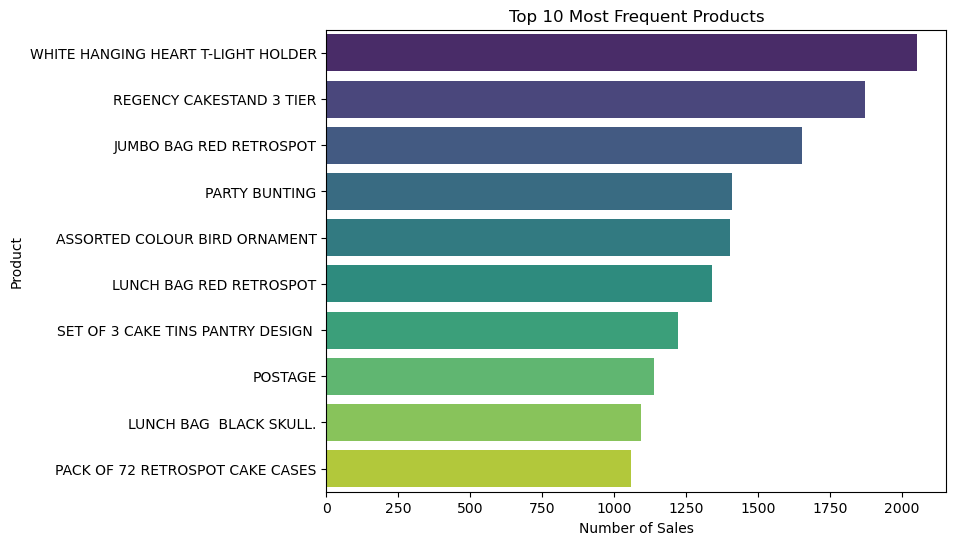

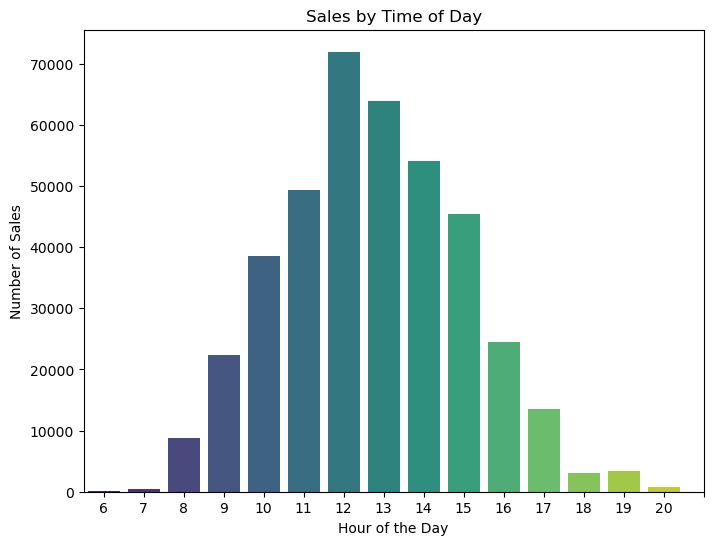

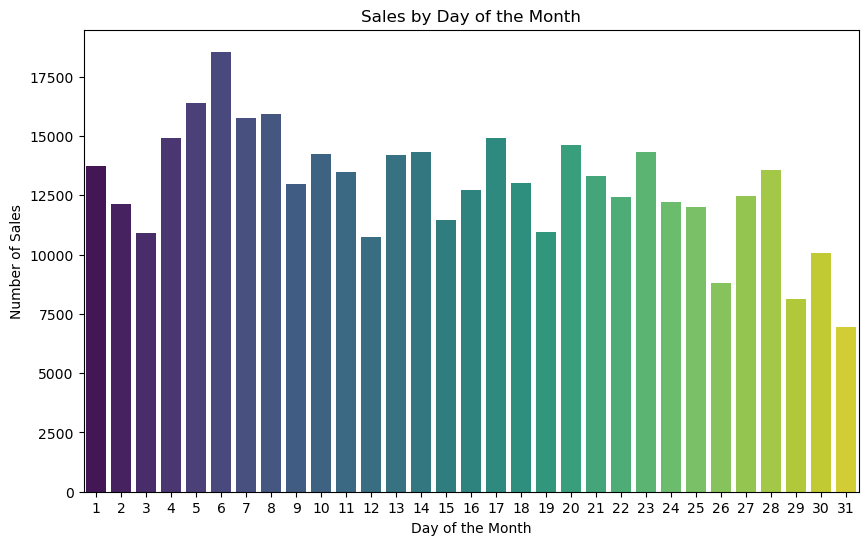

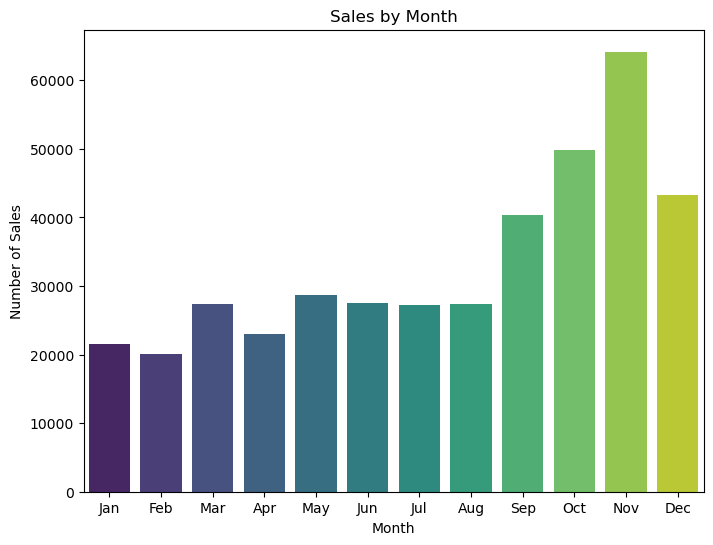

In [12]:
# Most Frequent Products
top_products = all_data['description'].value_counts().head(10)
plt.figure(figsize=(8, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Most Frequent Products')
plt.xlabel('Number of Sales')
plt.ylabel('Product')
plt.show()

# Sales by Time of Day
sales_by_hour = all_data['hour'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=sales_by_hour.index, y=sales_by_hour.values, palette='viridis')
plt.title('Sales by Time of Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Sales')
plt.xticks(range(0,16))
plt.show()

# Sales by Day of month
sales_by_day = all_data['day'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_day.index, y=sales_by_day.values, palette='viridis')
plt.title('Sales by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Sales')
plt.xticks(range(0, 31))
plt.show()

# Sales by Month
sales_by_month = all_data['month'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=sales_by_month.index, y=sales_by_month.values, palette='viridis')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Number of Sales')
plt.xticks(ticks=range(0, 12), labels=['Jan',
                                       'Feb',
                                       'Mar',
                                       'Apr',
                                       'May',
                                       'Jun',
                                       'Jul',
                                       'Aug',
                                       'Sep',
                                       'Oct',
                                       'Nov',
                                       'Dec'])
plt.show()

- ### Customer Demographics

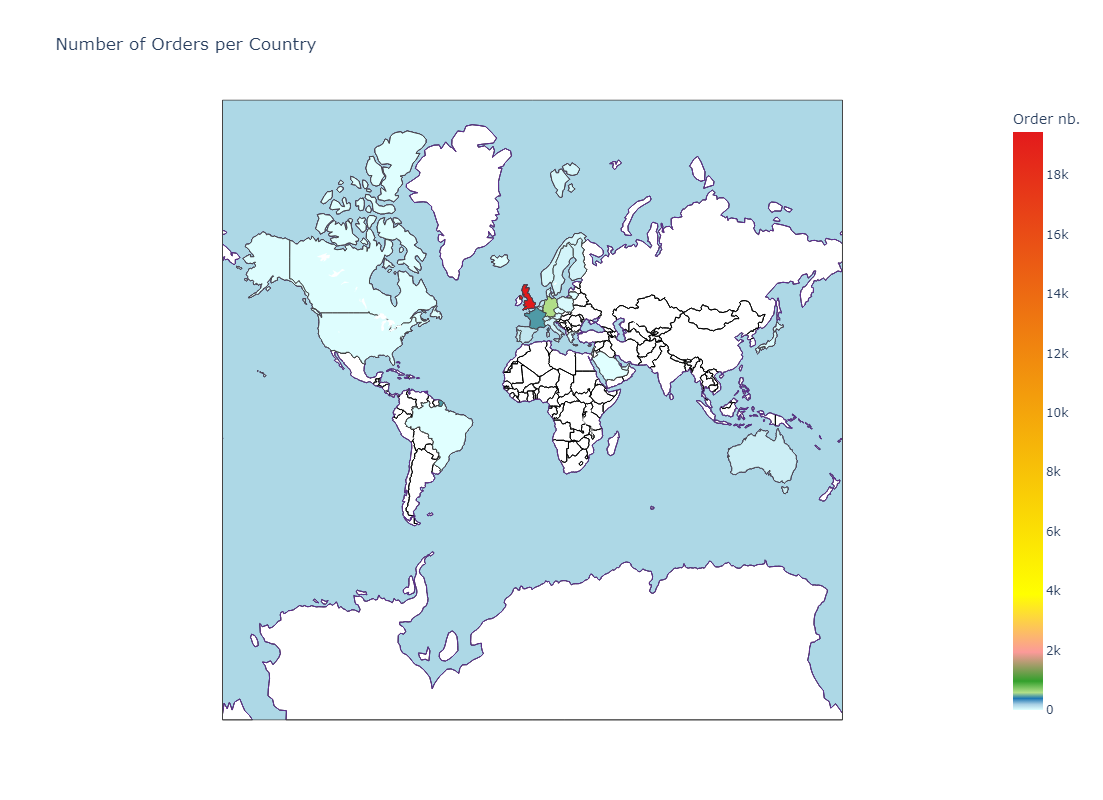

In [13]:
orders_per_country = all_data.groupby('country')['invoice_id'].nunique()

data = dict(
    type='choropleth',
    locations=orders_per_country.index,
    locationmode='country names',
    z=orders_per_country,
    text=orders_per_country.index,
    colorbar={'title': 'Order nb.'},
    colorscale=[
        [0, 'rgb(224,255,255)'],
        [0.01, 'rgb(166,206,227)'],
        [0.02, 'rgb(31,120,180)'],
        [0.03, 'rgb(178,223,138)'],
        [0.05, 'rgb(51,160,44)'],
        [0.10, 'rgb(251,154,153)'],
        [0.20, 'rgb(255,255,0)'],
        [1, 'rgb(227,26,28)']
    ],
    reversescale=False
)

layout = dict(
    title='Number of Orders per Country',
    geo=dict(
        showframe=True,
        projection={'type': 'mercator'},
        showcoastlines=True,
        coastlinecolor="RebeccaPurple",
        showland=True,
        landcolor="white",
        showocean=True,
        oceancolor="lightblue",
        showcountries=True,
        countrycolor="black"
    ),
    width=1100,
    height=800
)

choromap = go.Figure(data=[data], layout=layout)

# Display the map
iplot(choromap, validate=False)

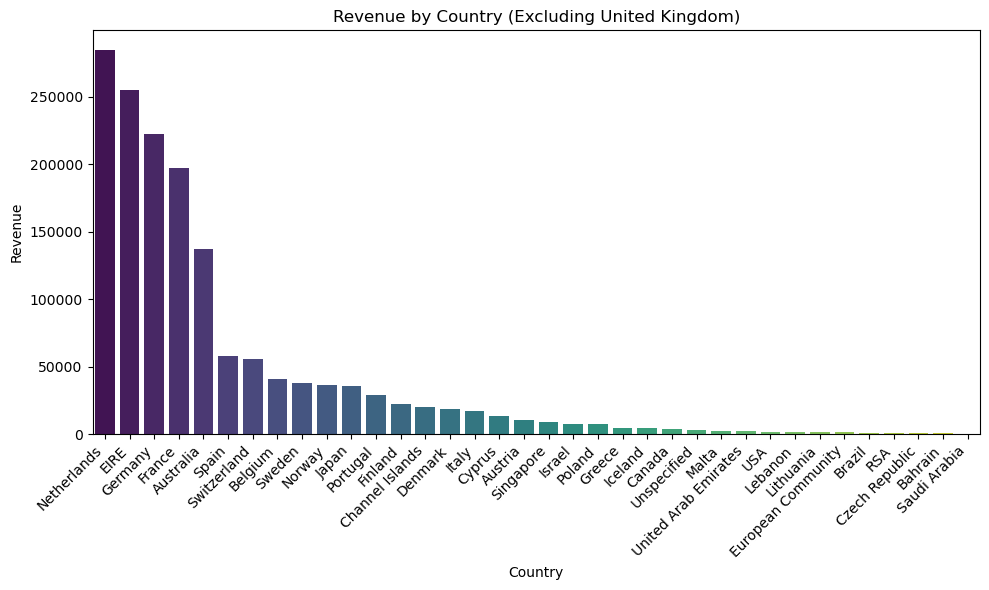

In [14]:
data_excluding_uk = all_data[all_data['country'] != 'United Kingdom']

# Calculate revenue by country (excluding the UK)
revenue_by_country = data_excluding_uk.groupby('country')['invoice_amount'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=revenue_by_country.index, y=revenue_by_country.values, palette='viridis')
plt.title('Revenue by Country (Excluding United Kingdom)')
plt.xlabel('Country')
plt.ylabel('Revenue')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()

***

### NLP-Driven Product Categorization via Clustering

In [15]:
print(f"Total Number of product descriptions: {all_data['description'].unique().size}")

Total Number of product descriptions: 3878


We aim to organize a large set of product descriptions — totaling 3,878 entries — into distinct categories. The primary motivation is to identify inherent groupings within the descriptions, revealing patterns and similarities that are not immediately obvious. By applying a combination of text preprocessing techniques, including keyword extraction, noun identification, and price range analysis, we prepare the data for effective clustering. This approach allows us to categorize each description into distinct groups based on textual and contextual similarities, facilitating more efficient data management and enhancing search functionality, ultimately improving our customer segmentation.

- ### Noun Identification and Key Term Extraction
  1. **Noun Identification:** We use part-of-speech tagging to determine whether a word in a product description is a noun. This is critical as nouns often carry the most significant meaning of the text.

  2. **Key Term Extraction:** After identifying nouns, we apply stemming to reduce words to their root form, ensuring that different forms of the same word are recognized as one. This helps in accurately quantifying the importance and frequency of each term across product descriptions.

  3. **Visualization Preparation:** Finally, we prepare these extracted keywords for visualization, which will help in analyzing the frequency and relevance of each term in the context of online retail products.


In [16]:
# Function to determine if a tag is a noun
def check_if_noun(tag):
    """
    Check if a part-of-speech tag is a noun.
    (Nouns:
    'NN': Singular Noun
    'NNS': Plural Noun
    'NNP': Proper Singular Noun
    'NNPS': Proper Plural Noun)

    Parameters:
    tag: Part-of-speech tag.
    
    Returns:
    True if the tag represents a noun, False otherwise.
    """

    # Set of noun tags
    noun_tags = {'NN', 'NNS', 'NNP', 'NNPS'}
    
    return tag in noun_tags

In [17]:
# Function to extract key terms from descriptions
def extract_key_terms(df, col='description'):
    """
    Extract key terms (nouns) from the product descriptions.
    
    Parameters:
    df: DataFrame containing product descriptions.
    col: Column name containing the descriptions.
    
    Returns:
    tuple: Contains unique terms, root to words mapping, root to term mapping, and term counts.
    """
    word_stemmer = nltk.stem.SnowballStemmer("english")  # Initialize the stemmer
    stemmed_root_to_words = {}  # Dictionary to map each stemmed root to a set of words/descriptions
    stemmed_root_to_representative = {}   # Dictionary to map each stemmed root to a representative word
    final_unique_terms = []   # List to store the final set of unique terms
    stemmed_root_to_counts = {}    # Dictionary to map each stemmed root to its frequency count
    
    # Process each description in the DataFrame
    descriptions = df[col].dropna().str.lower()  # Preprocess descriptions: drop NA and convert to lowercase
    for description in descriptions:
        tokens = nltk.word_tokenize(description)  # Tokenize the description into words
        pos_tags = nltk.pos_tag(tokens)  # Get part-of-speech tags for each token
        for word, tag in pos_tags:
            if check_if_noun(tag):  # Check if the token is a noun
                stemmed_root = word_stemmer.stem(word)  # Stem the noun to get its root form
                if stemmed_root not in stemmed_root_to_words:
                    stemmed_root_to_words[stemmed_root] = set()  # Initialize a set for new roots
                    stemmed_root_to_counts[stemmed_root] = 0  # Initialize the count for new roots
                stemmed_root_to_words[stemmed_root].add(word)  # Add the word to the set of words for this root
                stemmed_root_to_counts[stemmed_root] += 1  # Increment the count for this root

    # Select the shortest word as the representative term for each root
    for stemmed_root, words in stemmed_root_to_words.items():
        representative_word = min(words, key=len)  # Select the shortest word as the representative
        final_unique_terms.append(representative_word)  # Add the representative word to the list of unique terms
        stemmed_root_to_representative[stemmed_root] = representative_word  # Map the root to the representative word

    # Print the number of unique terms extracted
    print(f"Number of unique terms in column '{col}': {len(final_unique_terms)}")
    return final_unique_terms, stemmed_root_to_words, stemmed_root_to_representative, stemmed_root_to_counts

In [18]:
def prepare_keywords_for_visualization(root_to_representative, root_to_counts):
    """
    Prepare and sort keywords for visualization.
    
    Parameters:
    root_to_representative: Dictionary mapping each stemmed root to a representative word.
    root_to_counts: Dictionary mapping each stemmed root to its frequency count.
    
    Returns:
    Sorted list of keywords and their counts.
    """
    keywords_for_visualization = [
        [root_to_representative[stemmed_root], count] 
        for stemmed_root, count in root_to_counts.items()
    ]
    # Sort the keywords by their frequency counts in descending order
    keywords_for_visualization.sort(key=lambda x: x[1], reverse=True)
    return keywords_for_visualization

- ### Visualization of Key Terms

In [19]:
def visualize_word_cloud(term_counts, term_representatives):
    """
    Visualize the word cloud of the key terms.
    
    Parameters:
    term_counts: Dictionary with term frequency counts.
    term_representatives: Dictionary mapping roots to representative terms.
    """
    word_frequencies = {term_representatives[root]: count for root, count in term_counts.items()}
    wordcloud = WordCloud(width=1200,
                          height=800,
                          background_color='white',
                          colormap='coolwarm',
                          max_words=200).generate_from_frequencies(word_frequencies)
    
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud of Product Descriptions")
    plt.show()

def visualize_treemap(keywords_for_visualization):
    """
    Visualize the treemap of the key terms.
    
    Parameters:
    keywords_for_visualization: List of keywords and their frequency counts.
    """
    labels = [f"{word}\n{freq}" for word, freq in keywords_for_visualization[:30]]
    sizes = [freq for _, freq in keywords_for_visualization[:30]]
    
    # Reverse the 'coolwarm' colormap
    warmcool = cm.coolwarm(np.linspace(1, 0, 30))
    
    plt.figure(figsize=(15, 10))
    squarify.plot(sizes=sizes, label=labels, alpha=0.8, color=warmcool)
    plt.axis('off')
    plt.title("Words Occurrence in Product Descriptions")
    plt.show()

In [20]:
unique_descriptions = pd.DataFrame(all_data['description'].unique()).rename(columns = {0:'description'})

# Process keywords directly from all_data DataFrame
unique_keywords, stemmed_root_to_words, stemmed_root_to_representative, stemmed_root_to_counts = extract_key_terms(unique_descriptions,
                                                                                                                   col='description')

# Prepare keywords for visualization
keywords_for_visualization = prepare_keywords_for_visualization(stemmed_root_to_representative, stemmed_root_to_counts)

Number of unique terms in column 'description': 1478


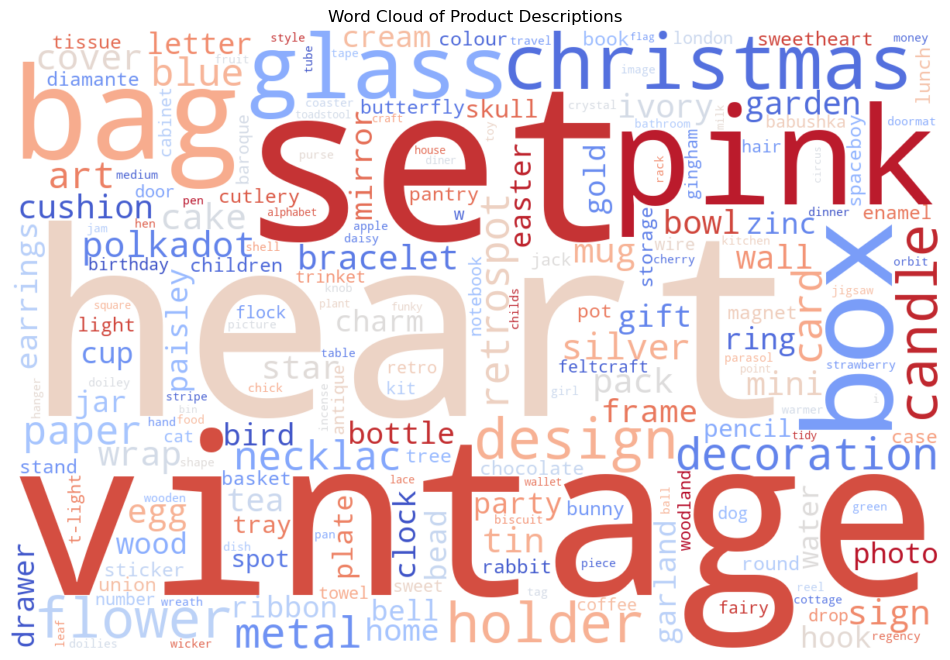

In [21]:
visualize_word_cloud(stemmed_root_to_counts, stemmed_root_to_representative)

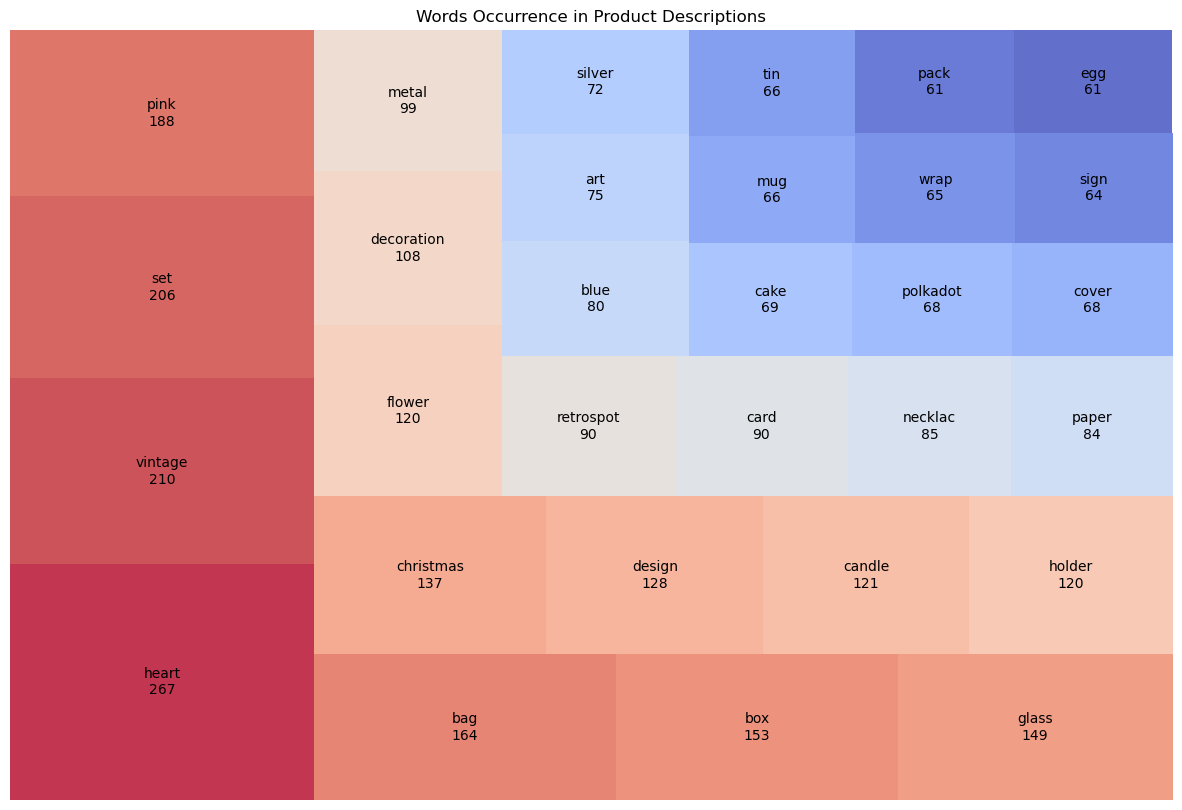

In [22]:
# Visualize the treemap
visualize_treemap(keywords_for_visualization)

- ### Keyword Filtering Strategy

    1. **Exclusions:** Words that are overly common or irrelevant to contextual analysis are excluded.
    2. **Minimum Length:** Ensures that the keywords retained are substantial enough to carry meaning.
    3. **Minimum Frequency:** Filters out keywords that appear infrequently, thereby focusing on terms that are more likely to have significant usage across the dataset.
    4. **Character Checks:** Removes words containing specific characters like '+' or '/', which may be errors or not useful for analysis.

In [23]:
def filter_keywords(stemmed_root_to_counts, stemmed_root_to_representative, exclusions, min_length, min_frequency):
    """
    Filter keywords based on specified criteria.
    
    Parameters:
    stemmed_root_to_counts: Dictionary of keyword counts.
    stemmed_root_to_representative: Dictionary of selected keywords.
    exclusions: List of words to exclude.
    min_length: Minimum length of keywords to retain.
    min_frequency: Minimum frequency of keywords to retain.
    
    Returns:
    Filtered list of keywords and their counts.
    """
    filtered_descriptions = []
    for stemmed_root, count in stemmed_root_to_counts.items():
        word = stemmed_root_to_representative[stemmed_root]
        if word in exclusions:
            continue
        if len(word) < min_length or count < min_frequency:
            continue
        if '+' in word or '/' in word:
            continue
        filtered_descriptions.append([word, count])
    
    filtered_descriptions.sort(key=lambda x: x[1], reverse=True)
    return filtered_descriptions

In [24]:
exclusions = ['pink',
              'white',
              'green',
              'orange',
              'blue',
              'tag']
min_length = 3
min_frequency = 13

filtered_descriptions = filter_keywords(stemmed_root_to_counts, stemmed_root_to_representative, exclusions, min_length, min_frequency)

- ### Preparing Data Matrix for Clustering
    1. **Keyword Columns:** We start by creating columns in our data matrix for each keyword identified in the product descriptions. This step transforms textual data into binary variables that indicate the presence or absence of each keyword in a description, facilitating textual analysis in a quantifiable form.
    
    2. **Price Range Columns:** We integrate pricing data by categorizing prices into predefined ranges, adding further dimensions to our matrix that reflect the economic segmentation of the products. Integrating price ranges is essential because segmenting price range products ensures the validity of the clustering outcomes by grouping products that are comparable in financial terms.

In [25]:
def prepare_data_matrix(filtered_products, descriptions, all_data):
    """
    Prepare a data matrix for clustering based on filtered keywords.
    
    Parameters:
    filtered_products: List of filtered keywords and their counts.
    descriptions: List of product descriptions.
    all_data: DataFrame containing all product data.
    
    Returns:
    DataFrame Data matrix with keywords and price range features.
    """
    data_dict = create_keyword_columns(filtered_products, descriptions)
    label_col = create_price_range_columns(data_dict, descriptions, all_data)
    
    X = pd.DataFrame(data_dict)
    return X

def create_keyword_columns(filtered_products, descriptions):
    """
    Create columns for each keyword in the descriptions.
    
    Parameters:
    filtered_products: List of filtered keywords and their counts.
    descriptions: List of product descriptions.
    
    Returns:
    Dictionary with keyword columns.
    """
    data_dict = {}
    for key, _ in filtered_products:
        data_dict[key] = [int(key.upper() in desc) for desc in descriptions]
    return data_dict

def create_price_range_columns(data_dict, descriptions, all_data):
    """
    Add price range columns to the data dictionary.
    
    Parameters:
    data_dict: Dictionary with keyword columns.
    descriptions: List of product descriptions.
    all_data: DataFrame containing all product data.
    
    Returns:
    List of price range labels.
    """
    threshold = [0, 1, 2, 3, 5, 10]
    label_col = generate_price_range_labels(threshold)
    
    initialize_price_range_columns(data_dict, label_col, descriptions)
    populate_price_range_columns(data_dict, label_col, descriptions, threshold, all_data)
    
    return label_col

def generate_price_range_labels(threshold):
    """
    Generate labels for the price range columns.
    
    Parameters:
    threshold: List of price thresholds.
    
    Returns:
    List of price range labels.
    """
    labels = []
    for i in range(len(threshold)):
        if i == len(threshold) - 1:
            labels.append('Above: {}'.format(threshold[i]))
        else:
            labels.append('Range: {}-{}'.format(threshold[i], threshold[i + 1]))
    return labels

def initialize_price_range_columns(data_dict, label_col, descriptions):
    """
    Initialize price range columns in the data dictionary.
    
    Parameters:
    data_dict: Dictionary with keyword columns.
    label_col: List of price range labels.
    descriptions: List of product descriptions.
    """
    for label in label_col:
        data_dict[label] = [0] * len(descriptions)

def populate_price_range_columns(data_dict, label_col, descriptions, threshold, all_data):
    """
    Populate the price range columns based on the descriptions.
    
    Parameters:
    data_dict: Dictionary with keyword columns.
    label_col: List of price range labels.
    descriptions: List of product descriptions.
    threshold: List of price thresholds.
    all_data: DataFrame containing all product data.
    """
    for i, prod in enumerate(descriptions):
        price = all_data[all_data['description'] == prod]['price_per_unit'].mean()
        for j in range(len(threshold)):
            if price <= threshold[j]:
                data_dict[label_col[j]][i] = 1
                break
            elif j == len(threshold) - 1:
                data_dict[label_col[j]][i] = 1

In [26]:
descriptions = all_data['description'].unique()

data_matrix = prepare_data_matrix(filtered_descriptions, descriptions, all_data)

In [27]:
display(data_matrix.head(3))

heart  vintage  set  bag  box  glass  christmas  design  candle  holder  \
0      1        0    0    0    0      0          0       0       0       1   
1      0        0    0    0    0      0          0       0       0       0   
2      1        0    0    0    0      0          0       0       0       0   

   ...  craft  lace  wallet  point  Range: 0-1  Range: 1-2  Range: 2-3  \
0  ...      0     0       0      0           0           0           0   
1  ...      0     0       0      0           0           0           0   
2  ...      0     0       0      0           0           0           0   

   Range: 3-5  Range: 5-10  Above: 10  
0           1            0          0  
1           0            1          0  
2           0            1          0  

[3 rows x 197 columns]

- ### Determining Optimal Number of Clusters using Elbow Method and Silhouette Scores

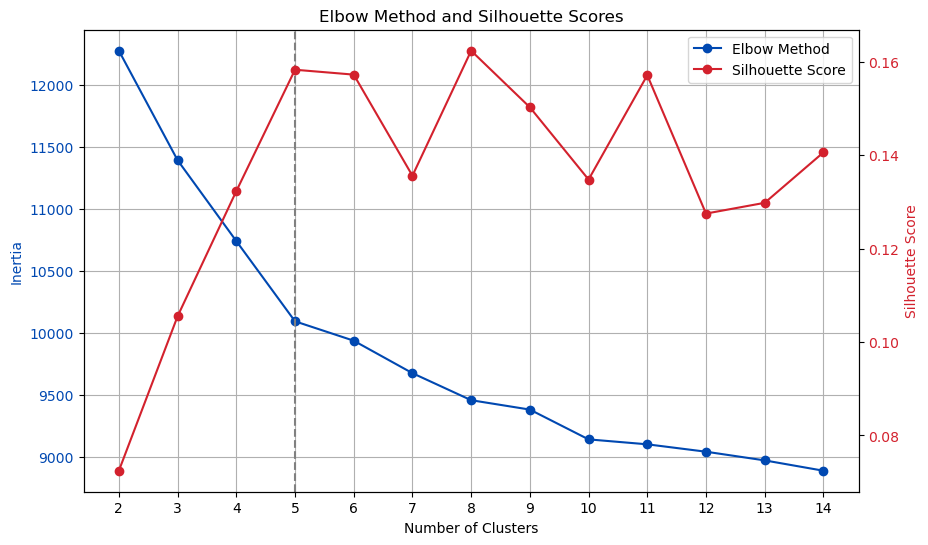

In [28]:
matrix = data_matrix.to_numpy()

inertias = []
silhouette_scores = []
k_values = range(2, 15)  

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(matrix)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(matrix, clusters))

fig, ax1 = plt.subplots(figsize=(10, 6))
color_elbow = '#0048B1'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia', color=color_elbow)
line1 = ax1.plot(k_values, inertias, marker='o', color=color_elbow,
                 label='Elbow Method')
ax1.tick_params(axis='y', labelcolor=color_elbow)
ax1.set_xticks(k_values)  
ax1.grid()

ax2 = ax1.twinx()
color_silhouette = '#D3212D'
ax2.set_ylabel('Silhouette Score', color=color_silhouette)
line2 = ax2.plot(k_values, silhouette_scores, marker='o', color=color_silhouette,
                 label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color_silhouette)
ax2.set_xticks(k_values)  # Ensure all ticks are shown

ax1.axvline(x=5, color='gray', linestyle='--')


lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title('Elbow Method and Silhouette Scores')
plt.show()

**By analyzing both the Elbow Method and Silhouette Scores, we observe that** $k = 5$ **seems to be the optimal number of clusters.**
1.  The Elbow plot shows a noticeable "bend" at $k = 5$, and the
2.  Silhouette Score's second highest and more stable peak is at $k = 5$.

In [29]:
optimal_k = 5

# Perform final clustering
kmeans = KMeans(n_clusters=optimal_k, n_init=30, random_state=42)
clusters = kmeans.fit_predict(matrix)

- ### t-SNE Visualization of Clusters

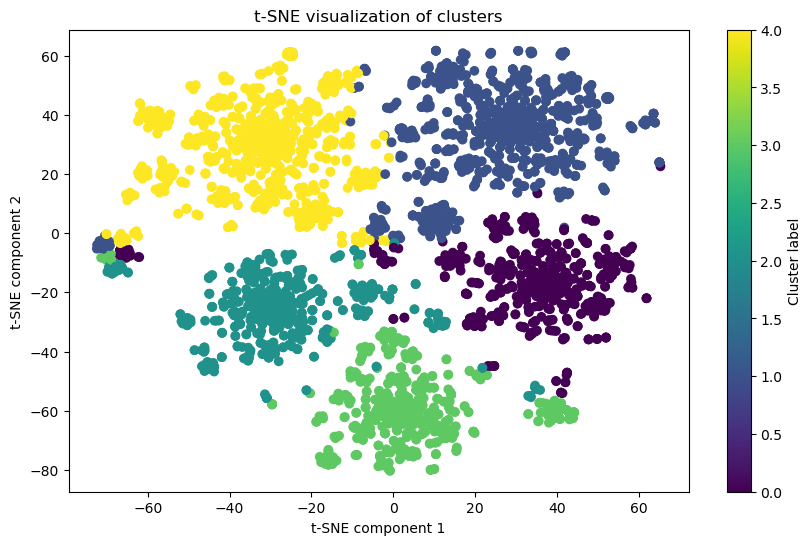

In [30]:
# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(matrix)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, cmap='viridis')
plt.title('t-SNE visualization of clusters')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar(label='Cluster label')
plt.show()

The t-SNE visualization demonstrates a well-defined separation among the clusters.The clusters appear cohesive, with most data points in each cluster grouping closely together. This cohesion suggests strong internal similarity among items within each cluster.
There is clear separation between most of the clusters, with only minimal overlap. This separation is a good indicator that the features used for clustering provide a strong basis for differentiation.
A few points lie outside the main clusters or near the boundaries. These outliers may represent unique or less common data points that did not fit well into the primary groups.

- ### Generating and Visualizing Word Clouds for Each Cluster

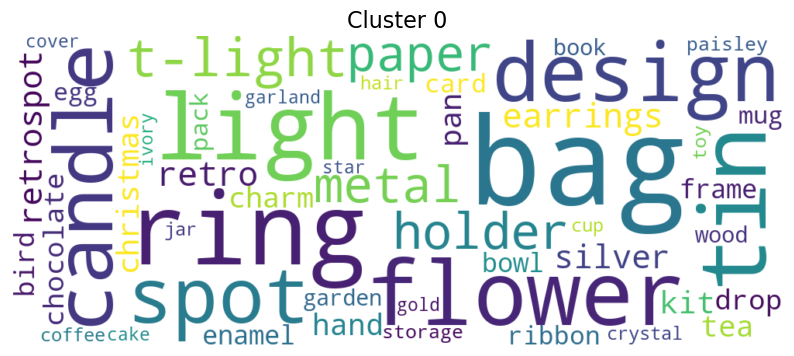

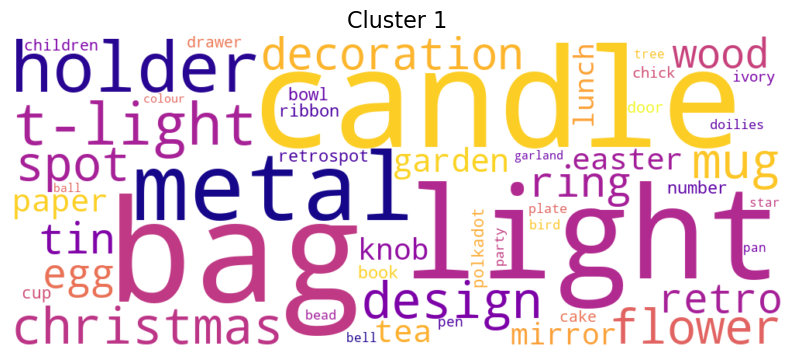

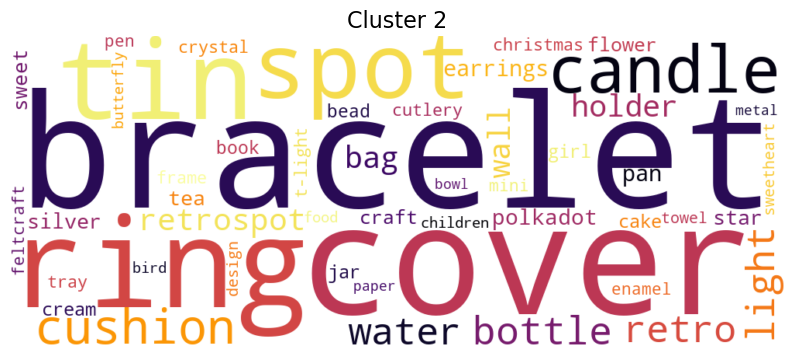

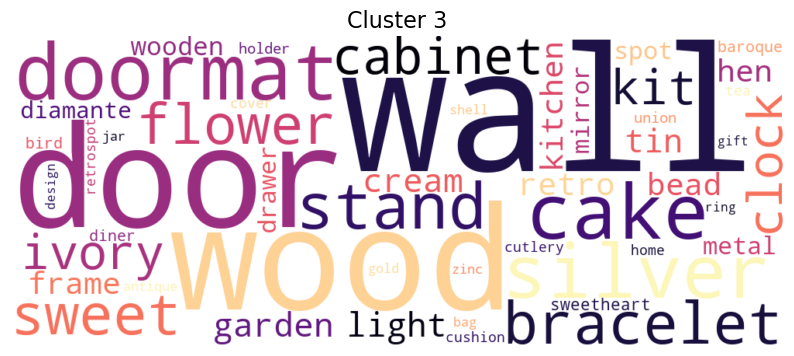

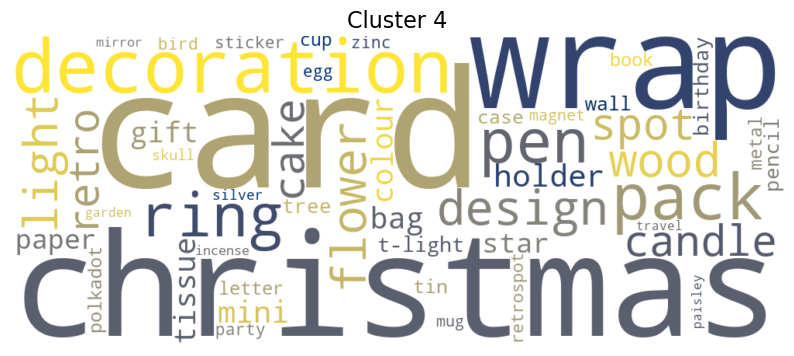

In [31]:
def generate_word_clouds(descriptions, clusters, filtered_products, optimal_k):
    """
    Generate and display word clouds for each cluster.
    
    Parameters:
    descriptions (array-like): List of product descriptions.
    clusters (array-like): Cluster labels for each description.
    filtered_products (list): List of filtered keywords and their counts.
    optimal_k (int): Optimal number of clusters.
    """
    color_maps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 
                  'spring', 'summer', 'autumn', 'winter', 'cool']

    occurrence = [dict() for _ in range(optimal_k)]

    for i in range(optimal_k):
        cluster_descriptions = descriptions[clusters == i]
        for word, _ in filtered_descriptions:
            if word.lower() in ['art',
                                'set',
                                'pink',
                                'blue',
                                'tag',
                                'glass',
                                'lace',
                                'pot',
                                'box',
                                'sign',
                                'vintage',
                                'heart',
                                'necklac']:
                continue
            occurrence[i][word] = sum(cluster_descriptions.str.contains(word.upper(), regex=False))

    for i in range(optimal_k):
        sorted_occurrences = sorted(occurrence[i].items(), key=lambda x: x[1], reverse=True)
        wordcloud = WordCloud(width=1000, height=400, background_color='white',
                              max_words=50, relative_scaling=0.5,
                              colormap=color_maps[i % len(color_maps)], normalize_plurals=False).generate_from_frequencies(dict(sorted_occurrences))
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.title(f'Cluster {i}', fontsize=16)
        plt.show()

descriptions = pd.Series(descriptions)

generate_word_clouds(descriptions, clusters, filtered_descriptions, optimal_k)

- ### Assigning Descriptive Category Names to Clusters
  Clusters are named based on observed themes and characteristics in the data. The names assigned to each cluster may not capture every aspect of the category, are indicative and designed to aid in analysis. They should not be considered definitive labels but rather as tools to facilitate better understanding and further exploration of the dataset.

In [32]:
category_names = {
    0: 'Vintage Design',
    1: 'Classic Artistry',
    2: 'Urban Home & Jewellery',
    3: 'Accessories',
    4: 'Holiday Essentials'
}

In [33]:
# Create a mapping dictionary from descriptions to cluster labels
description_to_cluster = pd.Series(clusters, index=descriptions).to_dict()

# Map the cluster labels back to the original DataFrame
all_data['category_id'] = all_data['description'].map(description_to_cluster)

# Map the cluster labels to the category name using the category_names dictionary
all_data['category'] = all_data['category_id'].map(category_names)

# Drop the intermediate category_id (cluster labels) column
all_data.drop(columns=['category_id'], inplace=True)

In [34]:
display(all_data.head(3))

invoice_id product_id                         description  quantity  \
0     536365     85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365      71053                 WHITE METAL LANTERN         6   
2     536365     84406B      CREAM CUPID HEARTS COAT HANGER         8   

         invoice_date  price_per_unit customer_id         country  \
0 2010-12-01 08:26:00            2.55     17850.0  United Kingdom   
1 2010-12-01 08:26:00            3.39     17850.0  United Kingdom   
2 2010-12-01 08:26:00            2.75     17850.0  United Kingdom   

   invoice_amount  year  month  day  hour  season                category  
0           15.30  2010     12    1     8  Winter          Vintage Design  
1           20.34  2010     12    1     8  Winter  Urban Home & Jewellery  
2           22.00  2010     12    1     8  Winter  Urban Home & Jewellery

***

- ###  Further Handling Negative Values in the Dataset Using Categories

Identify transactions with negative total prices within our dataset. Group data by customer and category, filtering out instances where total spending in a category is negative. Further isolate specific invoices that contribute to this negativity and set the total price of such transactions to zero. This adjustment is crucial for maintaining accurate and reliable records, preventing the distortion of analysis and reporting caused by negative values, which may arise from returns, discounts, or data entry errors.

In [35]:
# Set category columns as a categorical type for time efficiency 
if 'category' in all_data.columns:
    all_data['category'] = all_data['category'].astype('category')

# Filter to find groups where total spending is negative
negative_spending = all_data.groupby(['customer_id', 'category'], observed=True).filter(lambda x: x['invoice_amount'].sum() < 0)

# Find unique invoices with negative total prices within the filtered group
negative_invoices = negative_spending.groupby('invoice_id').filter(lambda x: x['invoice_amount'].sum() < 0)

# Identify the indexes of all transactions within these negative invoices that have negative total prices
negative_transactions_indexes = negative_invoices[negative_invoices['invoice_amount'] < 0].index

# Set their total price to zero
all_data.loc[negative_transactions_indexes, 'invoice_amount'] = 0
print(f"Total adjusted transactions: {len(negative_transactions_indexes)}")

# Convert categories back to string type for further processing if needed
all_data['category'] = all_data['category'].astype(str)

Total adjusted transactions: 72


- ### Categories Analysis: Revenue, Descriptions and Orders

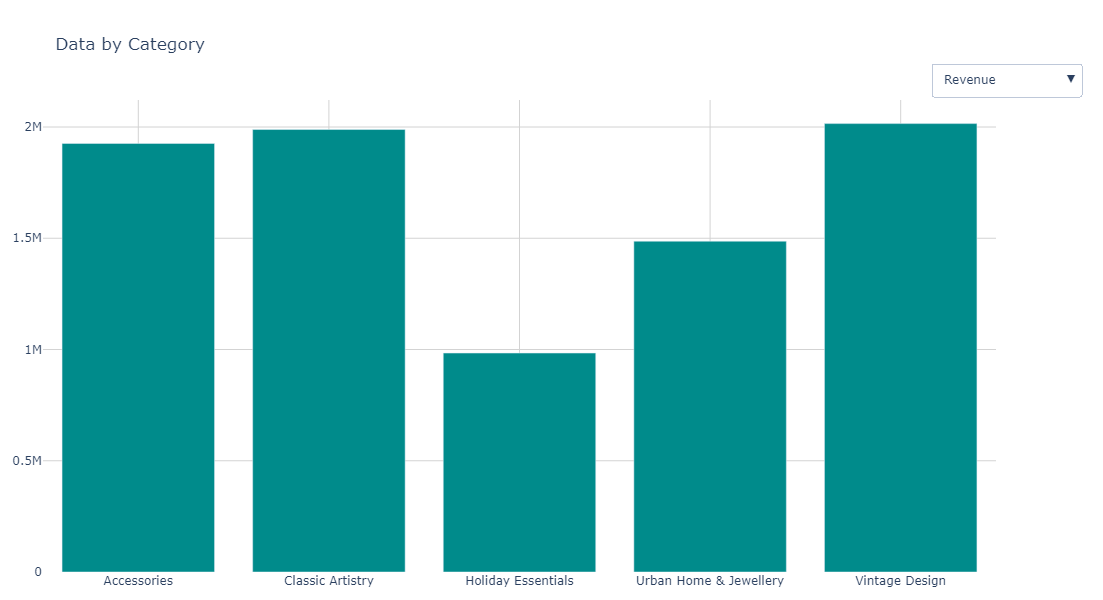

In [36]:
grouped = all_data.groupby('category')

revenue_by_category = grouped['invoice_amount'].sum()
description_counts = grouped['description'].nunique()
order_counts = grouped['invoice_id'].nunique()

fig = go.Figure()

fig.add_trace(go.Bar(x=revenue_by_category.index, y=revenue_by_category, name='', marker_color='darkcyan'))
fig.add_trace(go.Bar(x=description_counts.index, y=description_counts, name='', marker_color='darkcyan', visible=False))
fig.add_trace(go.Bar(x=order_counts.index, y=order_counts, name='', marker_color='darkcyan', visible=False))

fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(args=[{"visible": [True, False, False]},
                           {"title": "Revenue by Category"}],
                     label="Revenue", method="update"),
                dict(args=[{"visible": [False, True, False]},
                           {"title": "Unique Description Count by Category"}],
                     label="Descriptions", method="update"),
                dict(args=[{"visible": [False, False, True]},
                           {"title": "Number of Orders by Category"}],
                     label="Number of Orders", method="update")
            ]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=1.1,  
            xanchor="right",
            y=1.1,
            yanchor="top"
        ),
    ],
    title_text="Data by Category",
    width=1000,
    height=600,
    margin=dict(l=20, r=20, t=100, b=20),
    plot_bgcolor='white',  
    paper_bgcolor='white', 
    xaxis=dict(
        showgrid=True,  
        gridcolor='lightgrey'  
    ),
    yaxis=dict(
        showgrid=True,  
        gridcolor='lightgrey'  
    )
)

# Show the plot
fig.show()

***

### Saving Processed Data for Further Analysis

In [37]:
import os

file_path = os.path.join(os.getcwd(), 'processed_online_retail.csv')
all_data.to_csv(file_path, index=False)